<a href="https://colab.research.google.com/github/lilydia/Image-Classfication-Using-RayTune/blob/main/ImageSegmentationRayTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification Example

This example takes the image segmentation example provided by TensorFlow (https://www.tensorflow.org/tutorials/images/segmentation) and integrate it with model selection methods from RayTune (https://docs.ray.io/en/master/tune/tutorials/tune-serve-integration-mnist.html).

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
!pip install ray[tune]

In [ ]:
!pip install tensorboardx

In [ ]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(input_image, input_mask):
  #input_image = tf.image.resize(input_image, (128, 128)) #tf.image.resize(datapoint['image'], (128, 128))
  #input_mask = tf.image.resize(input_mask, (128, 128)) #tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask
  


In [ ]:
data_set_len = 0
for datapoint in dataset['train'].as_numpy_iterator():
  data_set_len += 1

In [ ]:
import numpy as np

train_set_x = np.zeros((data_set_len, 128, 128, 3))
train_set_y = np.zeros((data_set_len, 128, 128, 1))
i = 0
for datapoint in dataset['train'].as_numpy_iterator():
  #print(tf.image.resize(datapoint['image'], (128, 128)).numpy().shape)
  #print(datapoint['segmentation_mask'].shape)
  train_set_x[i, :, :, :] = tf.image.resize(datapoint['image'], (128, 128)).numpy() / np.float32(255)
  train_set_y[i, :, :, :] = tf.image.resize(datapoint['segmentation_mask'], (128, 128)).numpy().astype(np.int64)-1
  i += 1

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
model = 0

def test_base(config):

  base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 64x64
      'block_3_expand_relu',   # 32x32
      'block_6_expand_relu',   # 16x16
      'block_13_expand_relu',  # 8x8
      'block_16_project',      # 4x4
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

  down_stack.trainable = False

  up_stack = [
      pix2pix.upsample(512, 3),  # 4x4 -> 8x8
      pix2pix.upsample(256, 3),  # 8x8 -> 16x16
      pix2pix.upsample(128, 3),  # 16x16 -> 32x32
      pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

  ##################################### meat ##################################
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      config['threads'], 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)

  model.compile(optimizer=tf.keras.optimizers.SGD(
            lr=config["lr"], momentum=config["momentum"]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  
  show_predictions()

#def unet_model(output_channels):
  model_history = model.fit(train_set_x, train_set_y, epochs=3,
                          steps_per_epoch=3,
                          validation_steps=3,
                          validation_data=test_dataset,
                          callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])
  return model

In [ ]:

train_set_small = train_set_x[:1000]
train_set_small_y = train_set_y[:1000]
BATCH_SIZE = 16
def test_base2(config):

  base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

  # Use the activations of these layers
  layer_names = [
      'block_1_expand_relu',   # 64x64
      'block_3_expand_relu',   # 32x32
      'block_6_expand_relu',   # 16x16
      'block_13_expand_relu',  # 8x8
      'block_16_project',      # 4x4
  ]
  layers = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

  down_stack.trainable = False

  up_stack = [
      pix2pix.upsample(512, 3),  # 4x4 -> 8x8
      pix2pix.upsample(256, 3),  # 8x8 -> 16x16
      pix2pix.upsample(128, 3),  # 16x16 -> 32x32
      pix2pix.upsample(64, 3),   # 32x32 -> 64x64
    ]

  ##################################### meat ##################################
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      config['threads'], 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  model = tf.keras.Model(inputs=inputs, outputs=x)

  model.compile(optimizer=tf.keras.optimizers.SGD(
            lr=config["lr"], momentum=config["momentum"]),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


#def unet_model(output_channels):
  model_history = model.fit(train_set_small, train_set_small_y, epochs=3,
                            batch_size=BATCH_SIZE,
                          #steps_per_epoch=3,
                          #validation_steps=3,
                          #validation_data=test_dataset,
                          callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])

In [ ]:
  
import argparse
from tensorflow.keras.datasets import mnist
import tensorflow
import numpy as np

from ray.tune.integration.keras import TuneReportCallback

parser = argparse.ArgumentParser()
parser.add_argument(
    "--smoke-test", action="store_true", help="Finish quickly for testing")
args, _ = parser.parse_known_args()


def train_mnist(config):
    # https://github.com/tensorflow/tensorflow/issues/32159
    import tensorflow as tf
    batch_size = 128
    num_classes = 10
    epochs = 12

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    #x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train / np.float32(255)
    y_train = y_train.astype(np.int64)

    train_dataset = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(60000).repeat().batch(batch_size)    

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(config["hidden"], activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.SGD(
            lr=config["lr"], momentum=config["momentum"]),
        metrics=["accuracy"])

    model.fit(
        train_dataset,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=70,
        verbose=0,
        #validation_data=(x_test, y_test),
        callbacks=[TuneReportCallback({
            "mean_accuracy": "accuracy"
        })])


import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
mnist.load_data()  # we do this on the driver because it's not threadsafe

ray.shutdown()
ray.init(None)
sched = AsyncHyperBandScheduler(max_t=400, grace_period=20)

analysis = tune.run(
    #train_mnist,
    test_base2,
    name="exp",
    scheduler=sched,
    metric="mean_accuracy",
    mode="max",
    stop={
        "mean_accuracy": 0.99,
        "training_iteration": 5 if args.smoke_test else 300
    },
    num_samples=4,
    resources_per_trial={
        "cpu": 2,
        "gpu": 0
    },
    config={
        "threads": 3,
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.1, 0.9),
        "hidden": tune.randint(32, 512),
    })
print("Best hyperparameters found were: ", analysis.best_config)

11493376/11490434 [==============================] - 0s 0us/step


2021-03-16 23:50:46,505	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-03-16 23:50:49,036	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-03-16 23:51:03,506	WARNING worker.py:1107 -- Warning: The actor ImplicitFunc has size 524292237 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


Trial name,status,loc,hidden,lr,momentum
test_base2_71b8b_00000,RUNNING,,365,0.0896099,0.309798


(pid=406) 2021-03-16 23:51:07.972998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=406) 2021-03-16 23:51:10.454405: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=406) 2021-03-16 23:51:10.458288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
(pid=406) 2021-03-16 23:51:10.471231: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=406) 2021-03-16 23:51:10.471287: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 7d8e87899f9e
(pid=406) 2021-03-16 23:51:10.471298: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 7d8e87899f9e
(pid=406) 2021-03-16 23:51:10.471367: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200]

(pid=406) Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5
9412608/9406464 [==============================] - 0s 0us/step


(pid=406) 2021-03-16 23:51:12.262593: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
(pid=406) 2021-03-16 23:51:12.263016: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


(pid=406) Epoch 1/3


(pid=406) 2021-03-16 23:51:14.821748: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
(pid=406) 2021-03-16 23:51:14.830930: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25958400 exceeds 10% of free system memory.
(pid=406) 2021-03-16 23:51:15.258202: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 17825792 exceeds 10% of free system memory.
(pid=406) 2021-03-16 23:51:15.262070: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
(pid=406) 2021-03-16 23:51:15.341111: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.


22/63 [=========>....................]
(pid=406)  - ETA: 44s - loss: 2.3973 - accuracy: 0.4542
62/63 [============================>.] - ETA: 1s - loss: 2.2542 - accuracy: 0.5075
Result for test_base2_71b8b_00000:
  date: 2021-03-16_23-52-23
  done: false
  experiment_id: 90f54fd0768946a49bcb2534a7a7dba0
  hostname: 7d8e87899f9e
  iterations_since_restore: 1
  mean_accuracy: 0.583419680595398
  node_ip: 172.28.0.2
  pid: 406
  time_since_restore: 73.27538061141968
  time_this_iter_s: 73.27538061141968
  time_total_s: 73.27538061141968
  timestamp: 1615938743
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71b8b_00000
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00000,RUNNING,172.28.0.2:406,365,0.0896099,0.309798,0.58342,1,73.2754
test_base2_71b8b_00001,PENDING,,76,0.0905161,0.265591,,,


63/63 [==============================] - 71s 1s/step - loss: 2.2407 - accuracy: 0.5099
(pid=406) Epoch 2/3
62/63 [============================>.] - ETA: 1s - loss: 0.6313 - accuracy: 0.7746
Result for test_base2_71b8b_00000:
  date: 2021-03-16_23-53-32
  done: false
  experiment_id: 90f54fd0768946a49bcb2534a7a7dba0
  hostname: 7d8e87899f9e
  iterations_since_restore: 2
  mean_accuracy: 0.7998921871185303
  node_ip: 172.28.0.2
  pid: 406
  time_since_restore: 142.46799325942993
  time_this_iter_s: 69.19261264801025
  time_total_s: 142.46799325942993
  timestamp: 1615938812
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 71b8b_00000
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00000,RUNNING,172.28.0.2:406,365,0.0896099,0.309798,0.799892,2,142.468
test_base2_71b8b_00001,PENDING,,76,0.0905161,0.265591,,,


63/63 [==============================] - 69s 1s/step - loss: 0.6290 - accuracy: 0.7754
(pid=406) Epoch 3/3
62/63 [============================>.] - ETA: 1s - loss: 0.4137 - accuracy: 0.8441
Result for test_base2_71b8b_00000:
  date: 2021-03-16_23-54-41
  done: false
  experiment_id: 90f54fd0768946a49bcb2534a7a7dba0
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.8464776277542114
  node_ip: 172.28.0.2
  pid: 406
  time_since_restore: 211.28701901435852
  time_this_iter_s: 68.81902575492859
  time_total_s: 211.28701901435852
  timestamp: 1615938881
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00000
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00000,RUNNING,172.28.0.2:406,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,PENDING,,76,0.0905161,0.265591,,,


63/63 [==============================] - 69s 1s/step - loss: 0.4136 - accuracy: 0.8442
Result for test_base2_71b8b_00000:
  date: 2021-03-16_23-54-41
  done: true
  experiment_id: 90f54fd0768946a49bcb2534a7a7dba0
  experiment_tag: 0_hidden=365,lr=0.08961,momentum=0.3098
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.8464776277542114
  node_ip: 172.28.0.2
  pid: 406
  time_since_restore: 211.28701901435852
  time_this_iter_s: 68.81902575492859
  time_total_s: 211.28701901435852
  timestamp: 1615938881
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00000
  


2021-03-16 23:54:47,202	WARNING util.py:152 -- The `start_trial` operation took 5.446 s, which may be a performance bottleneck.


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00001,RUNNING,,76,0.0905161,0.265591,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287


(pid=405) 2021-03-16 23:54:50.641269: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=405) 2021-03-16 23:54:52.807012: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=405) 2021-03-16 23:54:52.807885: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
(pid=405) 2021-03-16 23:54:52.818847: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=405) 2021-03-16 23:54:52.818890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 7d8e87899f9e
(pid=405) 2021-03-16 23:54:52.818914: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 7d8e87899f9e
(pid=405) 2021-03-16 23:54:52.818994: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200]

(pid=405) Epoch 1/3


(pid=405) 2021-03-16 23:54:56.896224: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
(pid=405) 2021-03-16 23:54:56.905637: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25958400 exceeds 10% of free system memory.
(pid=405) 2021-03-16 23:54:57.329946: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 17825792 exceeds 10% of free system memory.
(pid=405) 2021-03-16 23:54:57.426526: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 41943040 exceeds 10% of free system memory.
(pid=405) 2021-03-16 23:54:57.484837: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 41943040 exceeds 10% of free system memory.


62/63 [============================>.] - ETA: 1s - loss: 2.2465 - accuracy: 0.5239
Result for test_base2_71b8b_00001:
  date: 2021-03-16_23-56-04
  done: false
  experiment_id: eab94d0ad0434d448333f4bb594b2a9a
  hostname: 7d8e87899f9e
  iterations_since_restore: 1
  mean_accuracy: 0.5772566199302673
  node_ip: 172.28.0.2
  pid: 405
  time_since_restore: 71.25520253181458
  time_this_iter_s: 71.25520253181458
  time_total_s: 71.25520253181458
  timestamp: 1615938964
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71b8b_00001
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00001,RUNNING,172.28.0.2:405,76,0.0905161,0.265591,0.577257,1,71.2552
test_base2_71b8b_00002,PENDING,,97,0.097246,0.205981,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287


63/63 [==============================] - 70s 1s/step - loss: 2.2338 - accuracy: 0.5255
(pid=405) Epoch 2/3
62/63 [============================>.] - ETA: 1s - loss: 0.6238 - accuracy: 0.7723
Result for test_base2_71b8b_00001:
  date: 2021-03-16_23-57-10
  done: false
  experiment_id: eab94d0ad0434d448333f4bb594b2a9a
  hostname: 7d8e87899f9e
  iterations_since_restore: 2
  mean_accuracy: 0.8032963871955872
  node_ip: 172.28.0.2
  pid: 405
  time_since_restore: 137.59741377830505
  time_this_iter_s: 66.34221124649048
  time_total_s: 137.59741377830505
  timestamp: 1615939030
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 71b8b_00001
  
63/63 [==============================] - 66s 1s/step - loss: 0.6211 - accuracy: 0.7733


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00001,RUNNING,172.28.0.2:405,76,0.0905161,0.265591,0.803296,2,137.597
test_base2_71b8b_00002,PENDING,,97,0.097246,0.205981,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287


(pid=405) Epoch 3/3
62/63 [============================>.] - ETA: 1s - loss: 0.4316 - accuracy: 0.8400
Result for test_base2_71b8b_00001:
  date: 2021-03-16_23-58-16
  done: false
  experiment_id: eab94d0ad0434d448333f4bb594b2a9a
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.846247673034668
  node_ip: 172.28.0.2
  pid: 405
  time_since_restore: 203.52948236465454
  time_this_iter_s: 65.93206858634949
  time_total_s: 203.52948236465454
  timestamp: 1615939096
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00001
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00001,RUNNING,172.28.0.2:405,76,0.0905161,0.265591,0.846248,3,203.529
test_base2_71b8b_00002,PENDING,,97,0.097246,0.205981,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287


Result for test_base2_71b8b_00001:
  date: 2021-03-16_23-58-16
  done: true
  experiment_id: eab94d0ad0434d448333f4bb594b2a9a
  experiment_tag: 1_hidden=76,lr=0.090516,momentum=0.26559
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.846247673034668
  node_ip: 172.28.0.2
  pid: 405
  time_since_restore: 203.52948236465454
  time_this_iter_s: 65.93206858634949
  time_total_s: 203.52948236465454
  timestamp: 1615939096
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00001
  
63/63 [==============================] - 66s 1s/step - loss: 0.4309 - accuracy: 0.8402


2021-03-16 23:58:21,716	WARNING util.py:152 -- The `start_trial` operation took 5.367 s, which may be a performance bottleneck.


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00002,RUNNING,,97,0.097246,0.205981,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529


(pid=557) 2021-03-16 23:58:26.271411: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=557) 2021-03-16 23:58:27.770819: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=557) 2021-03-16 23:58:27.771745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
(pid=557) 2021-03-16 23:58:27.781875: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=557) 2021-03-16 23:58:27.781925: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 7d8e87899f9e
(pid=557) 2021-03-16 23:58:27.781936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 7d8e87899f9e
(pid=557) 2021-03-16 23:58:27.782009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200]

(pid=557) Epoch 1/3


(pid=557) 2021-03-16 23:58:31.831237: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
(pid=557) 2021-03-16 23:58:31.837630: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25958400 exceeds 10% of free system memory.
(pid=557) 2021-03-16 23:58:32.224500: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 17825792 exceeds 10% of free system memory.
(pid=557) 2021-03-16 23:58:32.227549: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.
(pid=557) 2021-03-16 23:58:32.307252: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 16777216 exceeds 10% of free system memory.


45/63 [====================>.........]
(pid=557)  - ETA: 19s - loss: 2.8761 - accuracy: 0.4835
62/63 [============================>.] - ETA: 1s - loss: 2.7311 - accuracy: 0.4994
Result for test_base2_71b8b_00002:
  date: 2021-03-16_23-59-39
  done: false
  experiment_id: 0bf9c292c1ae4817b3aded1c18220e88
  hostname: 7d8e87899f9e
  iterations_since_restore: 1
  mean_accuracy: 0.5630334615707397
  node_ip: 172.28.0.2
  pid: 557
  time_since_restore: 72.07280325889587
  time_this_iter_s: 72.07280325889587
  time_total_s: 72.07280325889587
  timestamp: 1615939179
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71b8b_00002
  
63/63 [==============================] - 70s 1s/step - loss: 2.7133 - accuracy: 0.5014
(pid=557) Epoch 2/3


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00002,RUNNING,172.28.0.2:557,97,0.097246,0.205981,0.563033,1,72.0728
test_base2_71b8b_00003,PENDING,,77,0.0742288,0.749943,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529


62/63 [============================>.] - ETA: 1s - loss: 0.5896 - accuracy: 0.7862
Result for test_base2_71b8b_00002:
  date: 2021-03-17_00-00-48
  done: false
  experiment_id: 0bf9c292c1ae4817b3aded1c18220e88
  hostname: 7d8e87899f9e
  iterations_since_restore: 2
  mean_accuracy: 0.8019465804100037
  node_ip: 172.28.0.2
  pid: 557
  time_since_restore: 140.53695631027222
  time_this_iter_s: 68.46415305137634
  time_total_s: 140.53695631027222
  timestamp: 1615939248
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 71b8b_00002
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00002,RUNNING,172.28.0.2:557,97,0.097246,0.205981,0.801947,2,140.537
test_base2_71b8b_00003,PENDING,,77,0.0742288,0.749943,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529


63/63 [==============================] - 68s 1s/step - loss: 0.5883 - accuracy: 0.7867
(pid=557) Epoch 3/3
62/63 [============================>.] - ETA: 1s - loss: 0.5401 - accuracy: 0.8180
Result for test_base2_71b8b_00002:
  date: 2021-03-17_00-01-56
  done: false
  experiment_id: 0bf9c292c1ae4817b3aded1c18220e88
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.8406462073326111
  node_ip: 172.28.0.2
  pid: 557
  time_since_restore: 208.4079749584198
  time_this_iter_s: 67.87101864814758
  time_total_s: 208.4079749584198
  timestamp: 1615939316
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00002
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00002,RUNNING,172.28.0.2:557,97,0.097246,0.205981,0.840646,3,208.408
test_base2_71b8b_00003,PENDING,,77,0.0742288,0.749943,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529


63/63 [==============================] - 68s 1s/step - loss: 0.5371 - accuracy: 0.8187
Result for test_base2_71b8b_00002:
  date: 2021-03-17_00-01-56
  done: true
  experiment_id: 0bf9c292c1ae4817b3aded1c18220e88
  experiment_tag: 2_hidden=97,lr=0.097246,momentum=0.20598
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.8406462073326111
  node_ip: 172.28.0.2
  pid: 557
  time_since_restore: 208.4079749584198
  time_this_iter_s: 67.87101864814758
  time_total_s: 208.4079749584198
  timestamp: 1615939316
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00002
  


2021-03-17 00:02:01,542	WARNING util.py:152 -- The `start_trial` operation took 5.350 s, which may be a performance bottleneck.


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00003,RUNNING,,77,0.0742288,0.749943,,,
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529
test_base2_71b8b_00002,TERMINATED,,97,0.097246,0.205981,0.840646,3,208.408


(pid=587) 2021-03-17 00:02:03.899358: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
(pid=587) 2021-03-17 00:02:05.248895: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
(pid=587) 2021-03-17 00:02:05.249762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
(pid=587) 2021-03-17 00:02:05.257847: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(pid=587) 2021-03-17 00:02:05.257894: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: 7d8e87899f9e
(pid=587) 2021-03-17 00:02:05.257903: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: 7d8e87899f9e
(pid=587) 2021-03-17 00:02:05.257970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200]

(pid=587) Epoch 1/3
62/63 [============================>.] - ETA: 1s - loss: 1.9187 - accuracy: 0.5696
Result for test_base2_71b8b_00003:
  date: 2021-03-17_00-03-17
  done: false
  experiment_id: aa4aebac193f42acbdf306c9d12dab04
  hostname: 7d8e87899f9e
  iterations_since_restore: 1
  mean_accuracy: 0.6732228398323059
  node_ip: 172.28.0.2
  pid: 587
  time_since_restore: 71.93924880027771
  time_this_iter_s: 71.93924880027771
  time_total_s: 71.93924880027771
  timestamp: 1615939397
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 71b8b_00003
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00003,RUNNING,172.28.0.2:587,77,0.0742288,0.749943,0.673223,1,71.9392
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529
test_base2_71b8b_00002,TERMINATED,,97,0.097246,0.205981,0.840646,3,208.408


63/63 [==============================] - 70s 1s/step - loss: 1.9004 - accuracy: 0.5729
(pid=587) Epoch 2/3
62/63 [============================>.] - ETA: 1s - loss: 0.4261 - accuracy: 0.8413
Result for test_base2_71b8b_00003:
  date: 2021-03-17_00-04-26
  done: false
  experiment_id: aa4aebac193f42acbdf306c9d12dab04
  hostname: 7d8e87899f9e
  iterations_since_restore: 2
  mean_accuracy: 0.8474056124687195
  node_ip: 172.28.0.2
  pid: 587
  time_since_restore: 141.0331473350525
  time_this_iter_s: 69.09389853477478
  time_total_s: 141.0331473350525
  timestamp: 1615939466
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 71b8b_00003
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00003,RUNNING,172.28.0.2:587,77,0.0742288,0.749943,0.847406,2,141.033
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529
test_base2_71b8b_00002,TERMINATED,,97,0.097246,0.205981,0.840646,3,208.408


63/63 [==============================] - 69s 1s/step - loss: 0.4255 - accuracy: 0.8415
(pid=587) Epoch 3/3
62/63 [============================>.] - ETA: 1s - loss: 0.3771 - accuracy: 0.8568
Result for test_base2_71b8b_00003:
  date: 2021-03-17_00-05-35
  done: false
  experiment_id: aa4aebac193f42acbdf306c9d12dab04
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.8590488433837891
  node_ip: 172.28.0.2
  pid: 587
  time_since_restore: 210.04346442222595
  time_this_iter_s: 69.01031708717346
  time_total_s: 210.04346442222595
  timestamp: 1615939535
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00003
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00003,RUNNING,172.28.0.2:587,77,0.0742288,0.749943,0.859049,3,210.043
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529
test_base2_71b8b_00002,TERMINATED,,97,0.097246,0.205981,0.840646,3,208.408


Result for test_base2_71b8b_00003:
  date: 2021-03-17_00-05-35
  done: true
  experiment_id: aa4aebac193f42acbdf306c9d12dab04
  experiment_tag: 3_hidden=77,lr=0.074229,momentum=0.74994
  hostname: 7d8e87899f9e
  iterations_since_restore: 3
  mean_accuracy: 0.8590488433837891
  node_ip: 172.28.0.2
  pid: 587
  time_since_restore: 210.04346442222595
  time_this_iter_s: 69.01031708717346
  time_total_s: 210.04346442222595
  timestamp: 1615939535
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 71b8b_00003
  


Trial name,status,loc,hidden,lr,momentum,acc,iter,total time (s)
test_base2_71b8b_00000,TERMINATED,,365,0.0896099,0.309798,0.846478,3,211.287
test_base2_71b8b_00001,TERMINATED,,76,0.0905161,0.265591,0.846248,3,203.529
test_base2_71b8b_00002,TERMINATED,,97,0.097246,0.205981,0.840646,3,208.408
test_base2_71b8b_00003,TERMINATED,,77,0.0742288,0.749943,0.859049,3,210.043


2021-03-17 00:05:35,327	INFO tune.py:450 -- Total run time: 886.30 seconds (881.57 seconds for the tuning loop).


63/63 [==============================] - 69s 1s/step - loss: 0.3770 - accuracy: 0.8568
Best hyperparameters found were:  {'threads': 3, 'lr': 0.07422875711245505, 'momentum': 0.7499425098718645, 'hidden': 77}


In [ ]:
model = unet_model(OUTPUT_CHANNELS)

tf.keras.utils.plot_model(model, show_shapes=True)

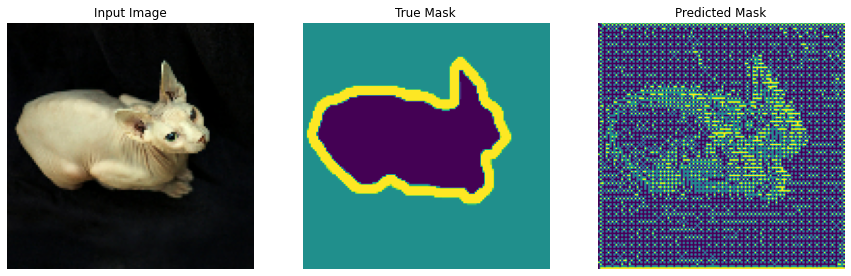

In [ ]:
show_predictions()

In [ ]:
#Plan A: GridSearchCV & RandomSearchCV
#Plan C: Keras wrapper

######################PLAN B
#Use random.choice to select combinations of hyperparameters
#Fix the algorithm to test 100 combinations? and choose the best combination(eg. particle swarm. soc gradient descent-built in packages).
import random

def random_param():
  EPOCHS_LIST = [5, 5, 5, 5] #default 20
  VAL_SUBSPLITS_LIST = [3,3,3] #default 5

  EPOCHS = random.choice(EPOCHS_LIST)
  VAL_SUBSPLITS = random.choice(VAL_SUBSPLITS_LIST)

  VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

  return EPOCHS, VAL_SUBSPLITS, VALIDATION_STEPS

EPOCHS, VAL_SUBSPLITS, VALIDATION_STEPS = random_param()

model_history = model.fit(train_dataset, epochs=3,
                          steps_per_epoch=3,
                          validation_steps=3,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])


AttributeError: ignored

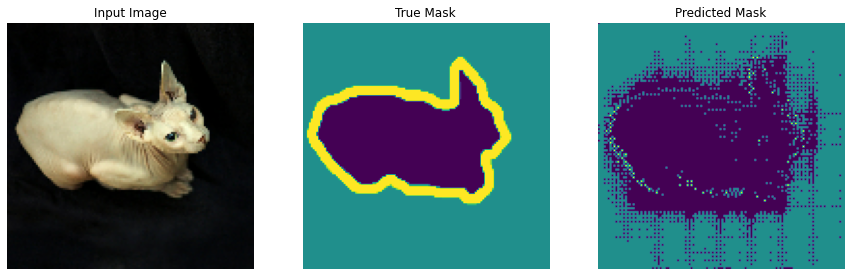


Sample Prediction after epoch 3



In [ ]:
model_history = model.fit(train_dataset, epochs=3,
                          steps_per_epoch=3,
                          validation_steps=3,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

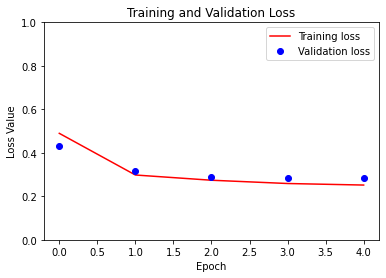

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

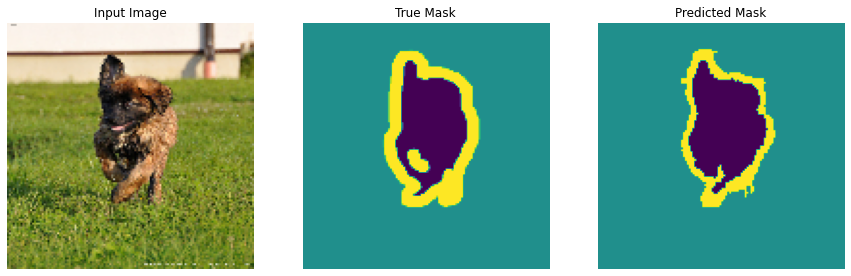

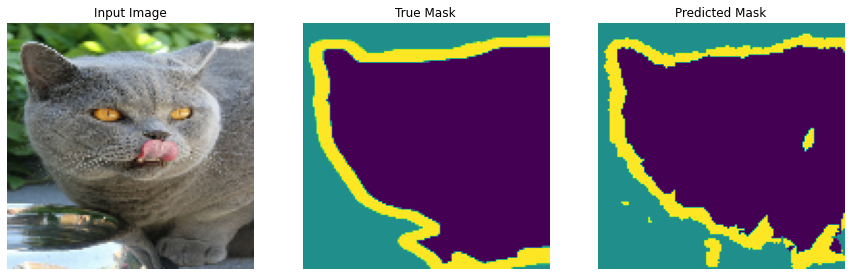

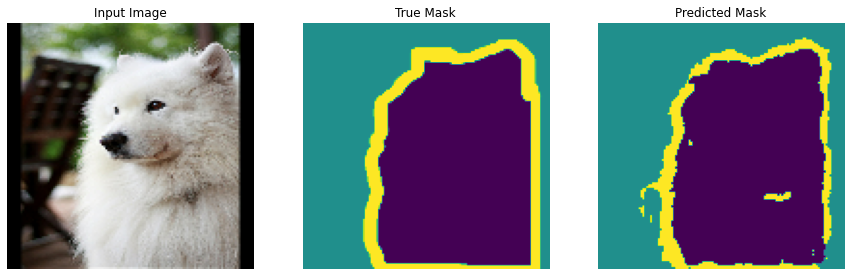

In [ ]:
show_predictions(test_dataset,3)